# Imports

In [1]:
import torch
import time
import os
import matplotlib.pyplot as plt
import numpy as np

from architecture import Generator
from super_image import EdsrModel, ImageLoader
from diffusers import StableDiffusionPipeline, DDPMScheduler
from torchvision.transforms import ToPILImage, ToTensor
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
from torchmetrics.functional.multimodal import clip_score
from functools import partial

/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-09 22:11:35.707127: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 22:11:36.547422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 22:11:37.702918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preparing models

In [2]:
#GAN
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "./new_generator_model.pth"
onehot = torch.zeros(10, 10, device=DEVICE).scatter_(1, torch.arange(10, device=DEVICE).view(10, 1), 1)
model = torch.load(PATH)
model = model.to("cuda")

# Stable diffusion
scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  3.79it/s]/home/alex/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


# Image generation functions

In [3]:
def gan_generation(class_num, num_images, model):
    image_list = []
    image_tensor = []
    noise = torch.randn(num_images, 100).to(DEVICE)
    class_selected = torch.tensor([class_num] * num_images).type(torch.LongTensor)
    label = onehot[class_selected].to(DEVICE)
    model.eval()
    with torch.no_grad():
        images = model(noise, label)
        for image in images:
            to_pil = ToPILImage()
            image_pil = to_pil(image.squeeze(0))
            image_resized = image_pil.resize((300, 300), Image.BILINEAR)
            image_list.append(image_resized)
            image_tensor.append(image)
    return image_list, images


def stable_diffusion_generation(word, pipe, num_images=1):
    prompt = (
        "A simple black and white outline of a " + word +
        " with no shading, drawn in MS Paint, with nothing inside. "
        "Make it look like something drawn in a charades game."
    )
    images = []
    for _ in range(num_images):
        image = pipe(
            prompt,
            scheduler=scheduler,
            num_inference_steps=30,
            guidance_scale=7.5
        ).images[0]
        images.append(image)
    return images


def display_images(images):
    for image in images:
        display(image)


# Image generation times comparision

In [17]:
labels = ["CGAN", "Diffusion"]

image_number = [1, 5, 10, 15, 20]
time_values_cgan = []
time_values_sd = []

for count in image_number:

    start = time.time()
    image_gan = gan_generation(1, count, model)
    cgan_time = time.time() - start

    start_time = time.time()
    image_sd = stable_diffusion_generation("apple", pipe, count)
    sd_time = time.time() - start_time

    time_values_cgan.append(cgan_time)
    time_values_sd.append(sd_time)

print(f"Times for CGAN: {time_values_cgan}")
print(f"Times for Stable Diffusion: {time_values_sd}")

100%|██████████| 30/30 [00:02<00:00, 10.00it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 30/30 [00:02<00:00, 10.10it/s]


Times for CGAN: [0.0016679763793945312, 0.001986265182495117, 0.0035948753356933594, 0.004439592361450195, 0.005866527557373047]
Times for Stable Diffusion: [3.1895642280578613, 15.635579109191895, 31.37560534477234, 47.03762769699097, 62.86700892448425]


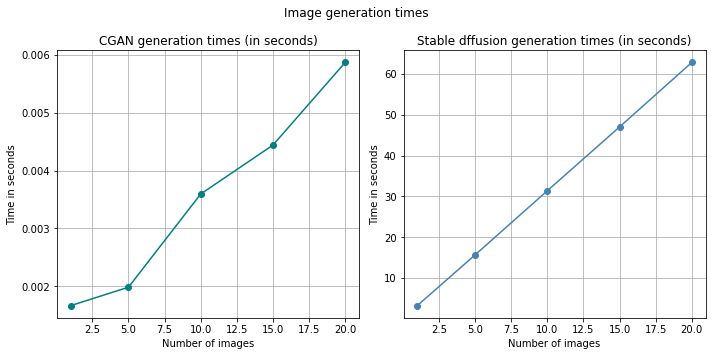

In [18]:
times= image_number
times_cgan = np.array(time_values_cgan)
times_sd = np.array(time_values_sd)

fig, ax =  plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(times, times_cgan, color='teal', marker='o')
ax[1].plot(times, times_sd, color='steelblue', marker='o')


ax[0].set_title('CGAN generation times (in seconds)')
ax[1].set_title('Stable dffusion generation times (in seconds)')
ax[0].set_xlabel('Number of images')
ax[1].set_xlabel('Number of images')

ax[0].set_ylabel('Time in seconds')
ax[1].set_ylabel('Time in seconds')

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Image generation times')
plt.tight_layout()
plt.show()

# Fréchet inception distance (FID)

In [6]:
def load_images(directory_path):
    image_files = [f for f in os.listdir(directory_path) if f.endswith(('.png'))]
    images = []
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        images.append(image)
    return images

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.Lambda(lambda img: img.convert("RGB")), 
    transforms.ToTensor()
])

labels = ["bucket", "apple", "shorts", "square", "circle", "sun", "carrot", "crown", "triangle", "car"]
true_images_list = []
fake_images_list = []
fid_scores = []

for i in range(0,10):
    images_gan, tensors_gan = gan_generation(i, 100, model)
    fake_images_list.append(images_gan)


for label in labels:
    true_images = load_images(f"./true_images/{label}")
    true_images_list.append(true_images)

for fake, real, label in zip(fake_images_list, true_images_list,labels):

    real = torch.stack([transform(img) for img in real]).to("cpu").to(torch.uint8)
    fake = torch.stack([transform(img) for img in fake]).to("cpu").to(torch.uint8)

    fid = FrechetInceptionDistance().to("cpu")
    fid.update(real, real=True)
    fid.update(fake, real=False)
    fid_score = fid.compute()
    fid_scores.append(fid_score.item())
    print(f"FID Score for {label}: {fid_score.item()}")

avg_score = np.average(fid_scores)
print(f"Average FID Score: {avg_score}")
    

Average FID Score: 46.71382923126221


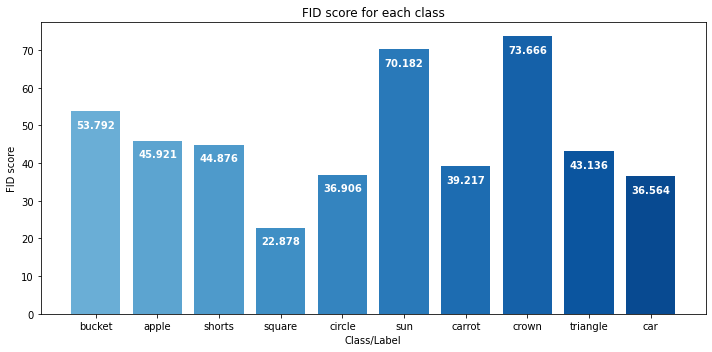

In [10]:
categories = labels
values = fid_scores
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(categories)))
fig = plt.figure(figsize = (10, 5))
bars = plt.bar(categories, values, color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{bar.get_height():.3f}', 
             ha='center', va='bottom', color="white", fontweight="bold")

plt.title('FID score for each class')
plt.xlabel('Class/Label')
plt.ylabel('FID score')
plt.tight_layout()
plt.show()

# CLIP score

In [14]:
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

prompt = [
        "A simple black and white outline of a bucket with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a apple with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a shorts with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a square with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a circle with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a sun with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a carrot with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a crown with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a triangle with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game.",
        "A simple black and white outline of a car with no shading, drawn in MS Paint, with nothing inside. Make it look like something drawn in a charades game."
]


def calculate_clip_score(images, prompts):
    torch.cuda.empty_cache()
    tensors = torch.stack([ToTensor()(img) for img in images])
    tensors = tensors.mul(255).to(torch.uint8).to(DEVICE)
    clip = clip_score_fn(tensors,prompts)
    return clip

images = [
    stable_diffusion_generation("bucket",pipe,1)[0],
    stable_diffusion_generation("apple",pipe,1)[0],
    stable_diffusion_generation("shorts",pipe,1)[0],
    stable_diffusion_generation("square",pipe,1)[0],
    stable_diffusion_generation("circle",pipe,1)[0],
    stable_diffusion_generation("sun",pipe,1)[0],
    stable_diffusion_generation("carrot",pipe,1)[0],
    stable_diffusion_generation("crown",pipe,1)[0],
    stable_diffusion_generation("triangle",pipe,1)[0],
    stable_diffusion_generation("car",pipe,1)[0]
]

sd_clip_score = calculate_clip_score(images, prompt)

print(f"CLIP score: {sd_clip_score}")

100%|██████████| 30/30 [00:02<00:00, 10.45it/s]
/home/alex/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP score: 34.05965805053711


# Mode collapse detection

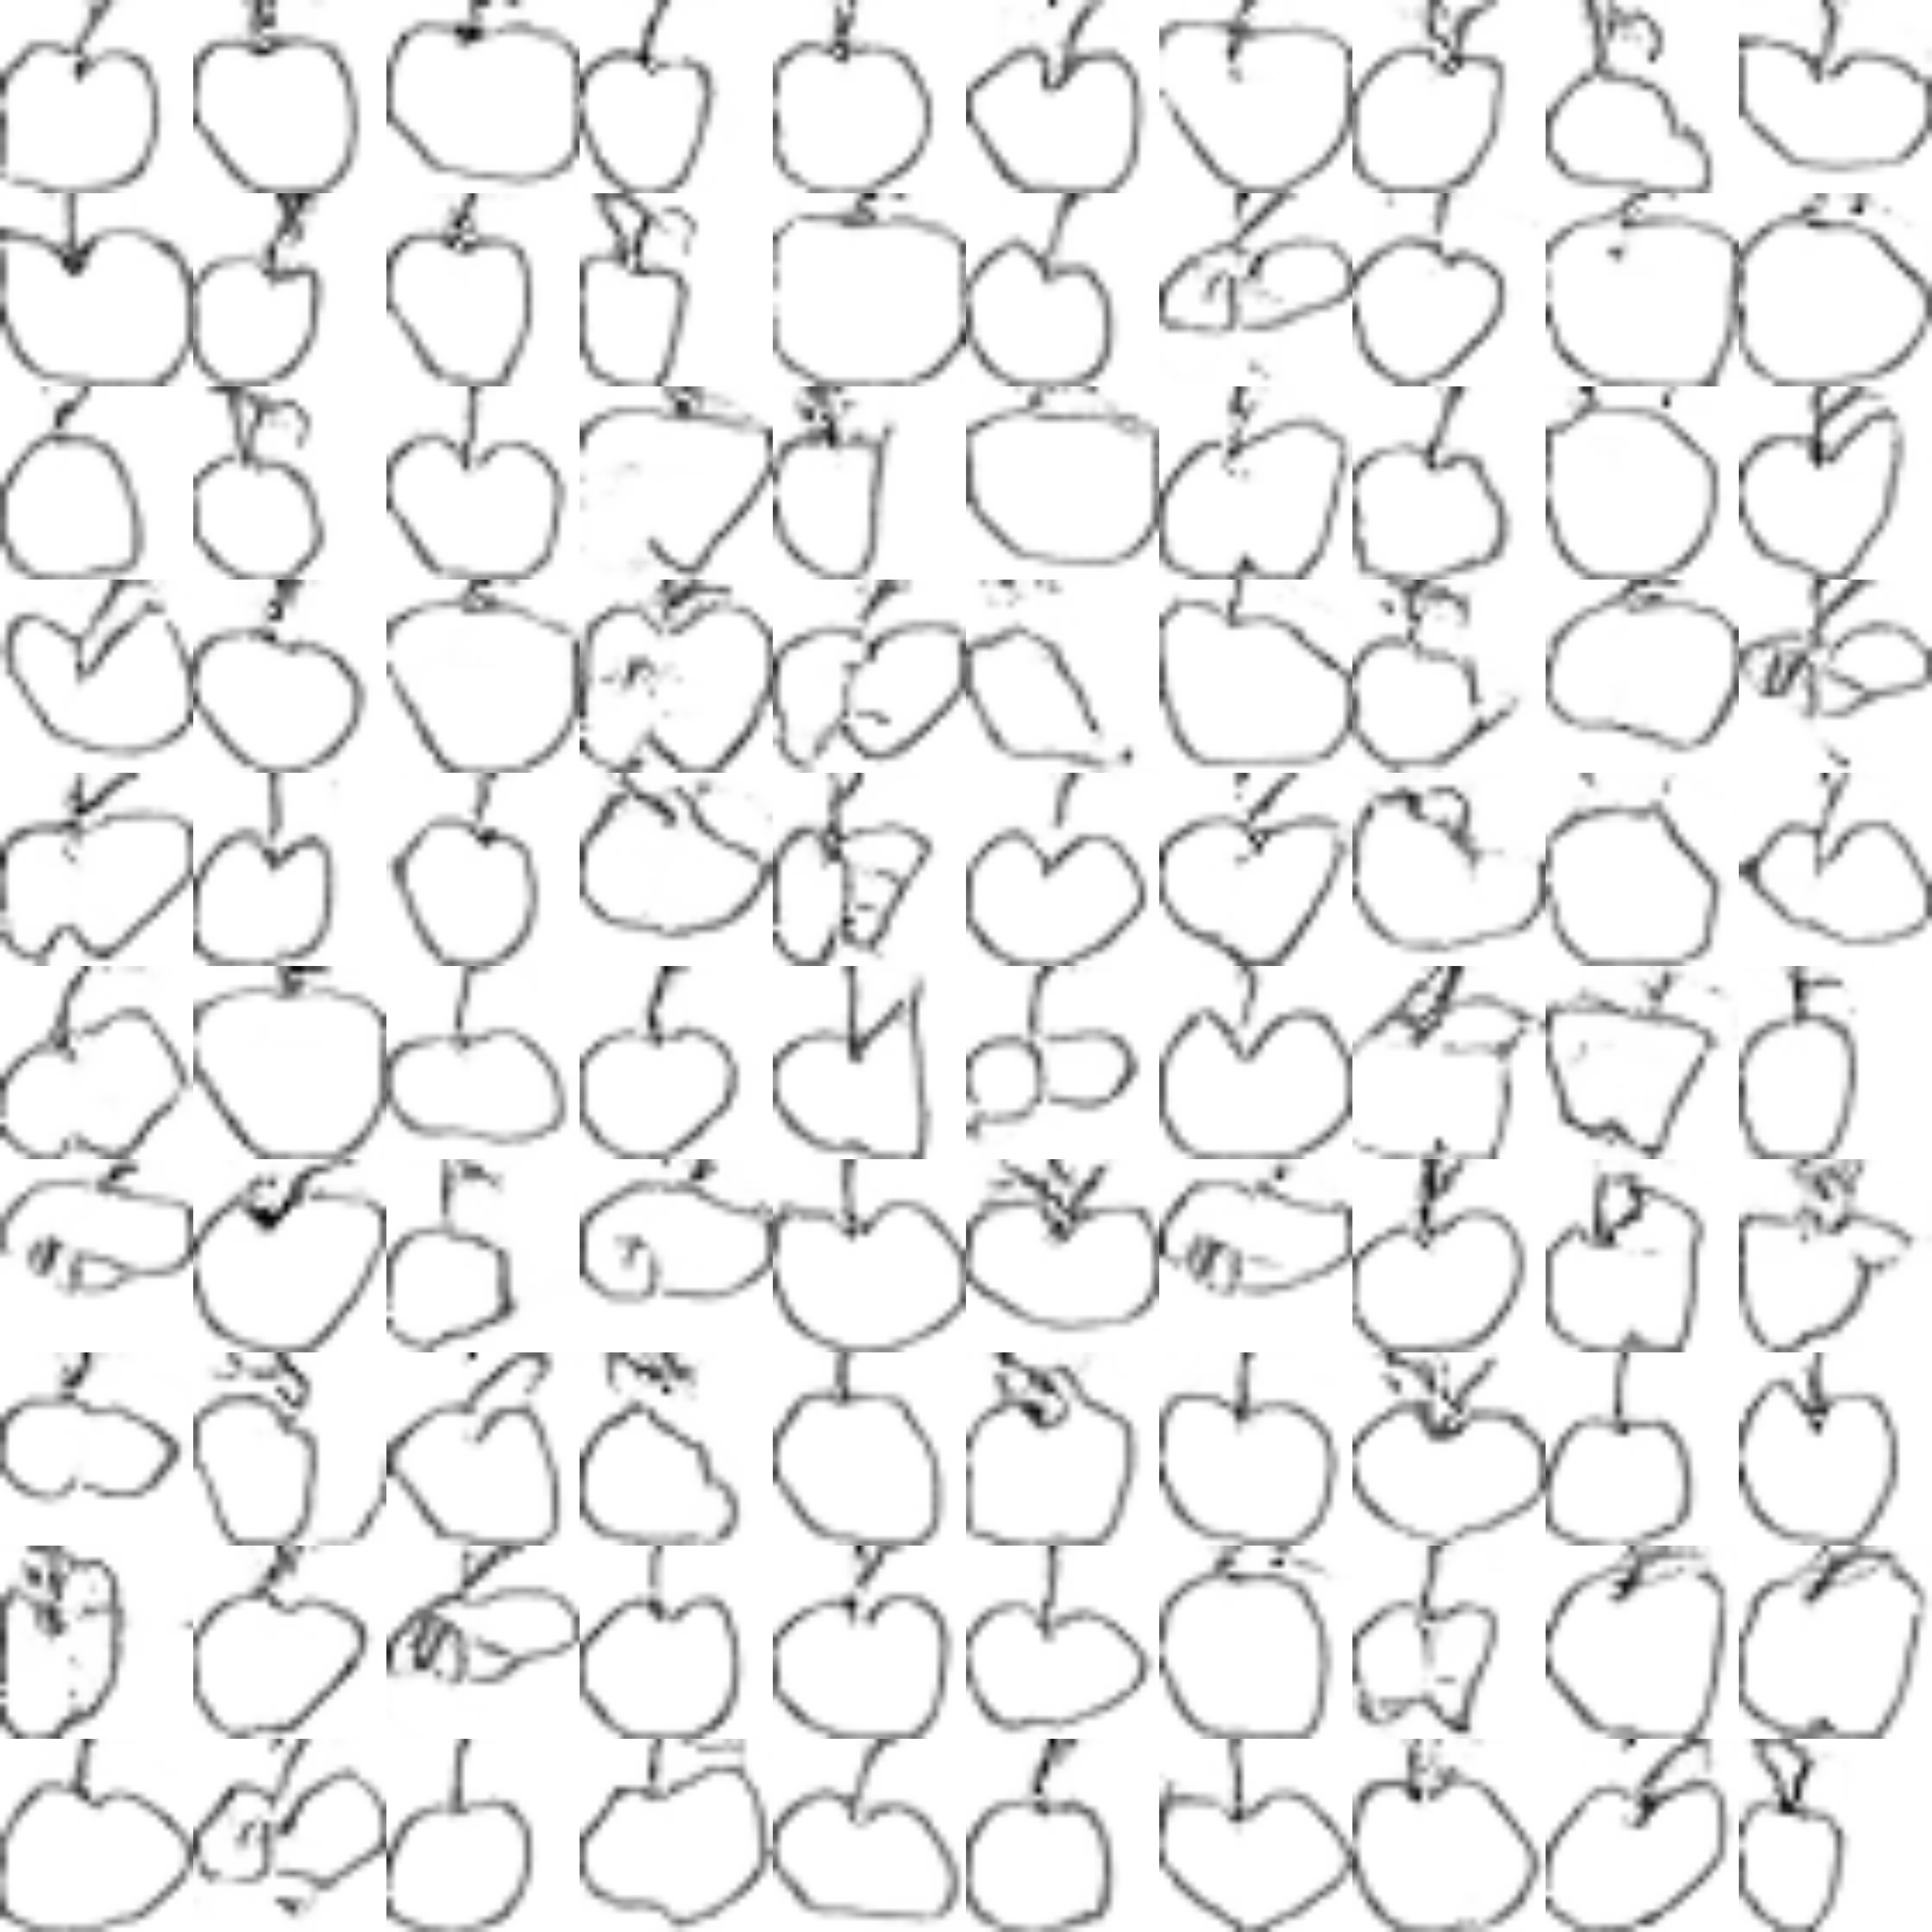

In [ ]:
mode_collapse, tensor = gan_generation(1,100,model)

def create_grid(images):
    img_size=(299, 299)
    size=(10, 10)
    width = size[0] * img_size[0]
    height = size[1] * img_size[1]
    grid_image = Image.new('RGB', (width, height))
    
    for i, image in enumerate(images):
        image = image.resize(img_size)
        row = i // size[1]
        col = i % size[1]
        x_offset = col * img_size[0]
        y_offset = row * img_size[1]
        grid_image.paste(image, (x_offset, y_offset))
    return grid_image

create_grid(mode_collapse)

100%|██████████| 30/30 [00:03<00:00,  9.76it/s]


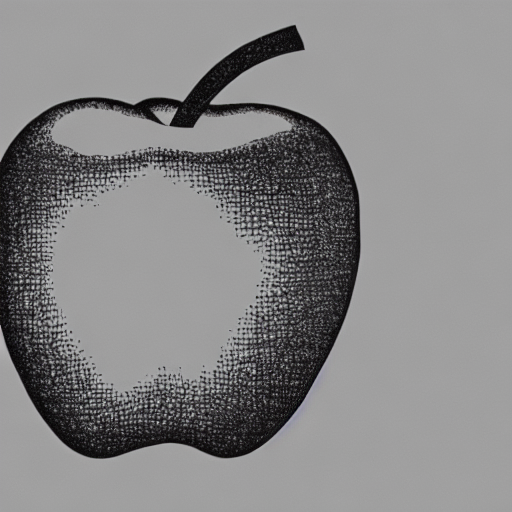

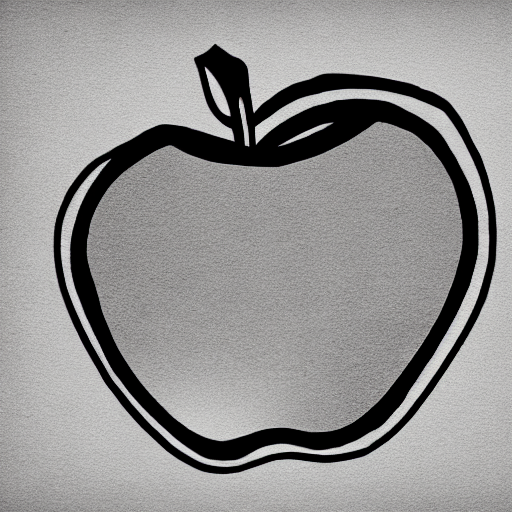

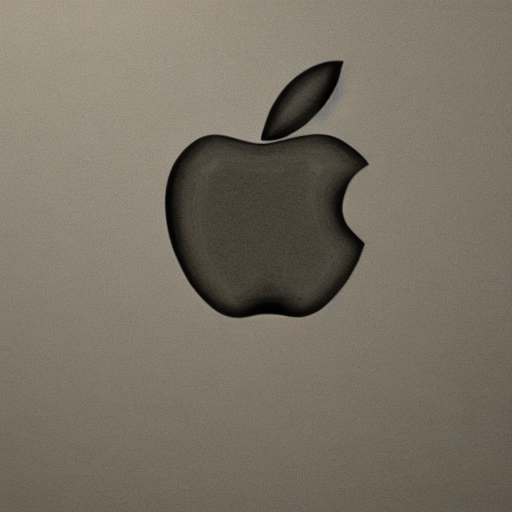

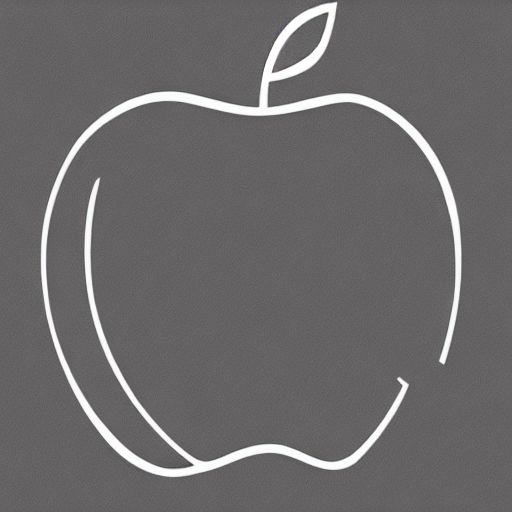

In [8]:
display_images(stable_diffusion_generation("apple",pipe,4))